In [1]:
import sys, os
import numpy as np
import keras
import csv
import cv2

from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Lambda, ELU
from keras.layers.convolutional import Convolution2D, Cropping2D

import matplotlib.pyplot as plt

from model import *

get_ipython().magic('matplotlib inline')
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'
plt.rcParams['axes.titlesize'] = 8


get_ipython().magic('load_ext autoreload')
get_ipython().magic('autoreload 2')


Using TensorFlow backend.


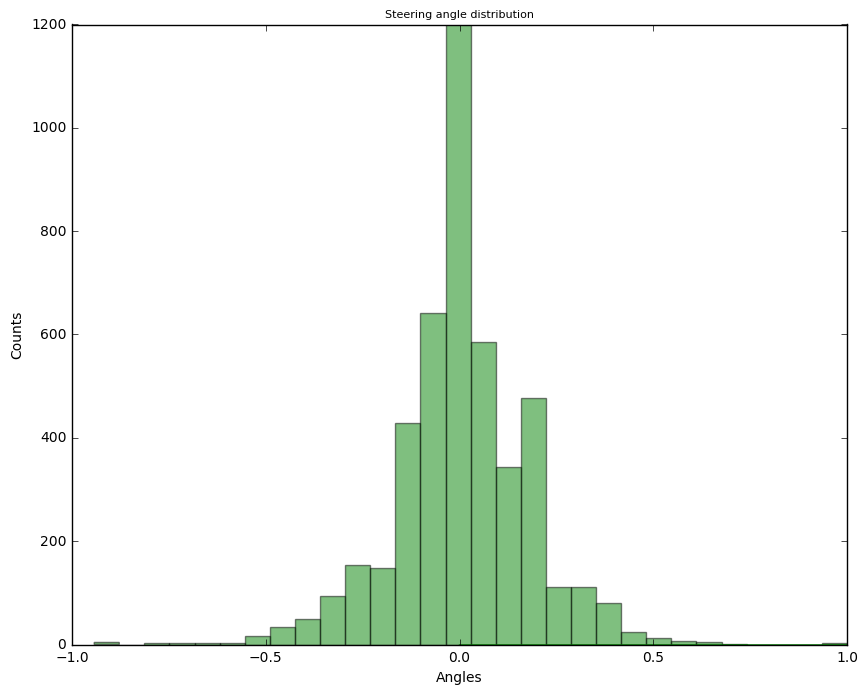

In [2]:
# Load the Udacity dataset. 
data_folder = "./data"
img_folder = "%s/IMG"%data_folder
steering_csv = "%s/driving_log.csv"%data_folder

steering = []
files = []

with open(steering_csv, 'r') as csvfile:
    rows = csv.reader(csvfile, delimiter=',')
    next(rows, None)
    for row in rows:
        steering.append(float(row[3]))
        files.append(["%s/%s"%(data_folder, row[i].strip()) for i in range(3)])

n, bins, _ = plt.hist(steering, 30, facecolor='green', alpha=0.5)
plt.plot(bins)
plt.title('Steering angle distribution')
plt.xlabel('Angles')
plt.ylabel('Counts')
plt.axis([-1, 1, 0, 1200])


#plt.show()
plt.savefig('angle_distribution.png')

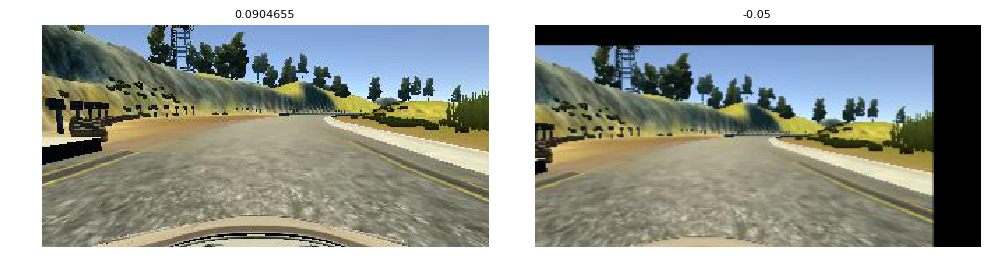

In [3]:
from preprocess import translate

idx = np.random.randint(len(files))
img = cv2.imread(files[idx][0])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)


plt.subplot(121)
plt.axis('off')
plt.imshow(img)
plt.title(steering[idx])

X, y = translate(img, steering[idx], 100, 40)
plt.subplot(122)
plt.axis('off')
plt.imshow(X)
plt.title("%0.2f"%(y))
plt.tight_layout()
plt.savefig('translate_example.png')

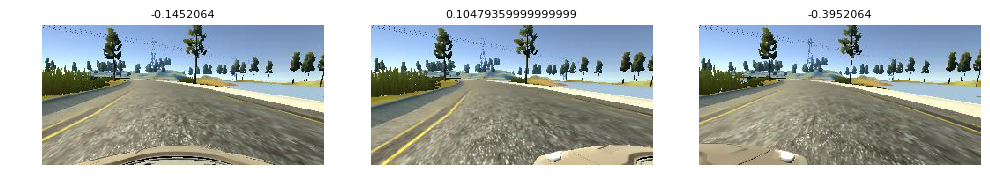

In [4]:
from preprocess import translate

idx = np.random.randint(len(files))
img = cv2.imread(files[idx][0])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)


plt.subplot(131)
plt.axis('off')
plt.imshow(img)
plt.title(steering[idx])

img = cv2.imread(files[idx][1])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.subplot(132)
plt.axis('off')
plt.imshow(img)
plt.title(steering[idx]+0.25)

img = cv2.imread(files[idx][2])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.subplot(133)
plt.axis('off')
plt.imshow(img)
plt.title(steering[idx]-0.25)

plt.tight_layout()
plt.savefig('left_right_camera.png')

In [5]:
def plot_random_sample(idxs, cols=3, camera=0):
    rows = int(np.ceil(len(idxs)/float(cols)))
    for i, idx in enumerate(idxs):
        img = cv2.imread(files[idx][camera])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.subplot(rows, cols,  i+1)
        plt.imshow(img)
        plt.axis('off')
        plt.title("steering angle: %.2f"%(steering[idx]))
    
    plt.savefig("sample_images.png")

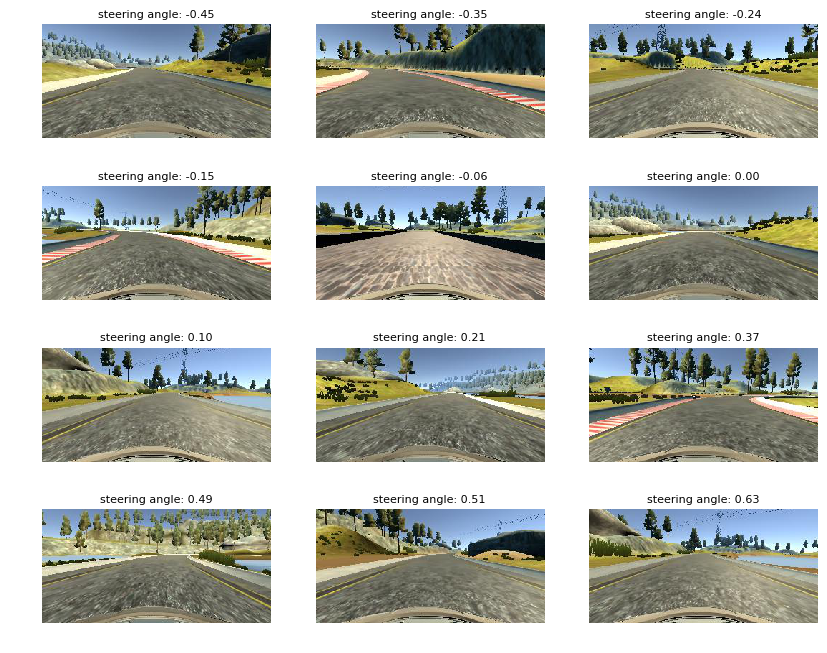

In [6]:
steering = np.array(steering)

angle = -0.5

subsample = []
for i in range(12):
    values = np.where(np.logical_and(steering >=angle, steering<(angle+0.1)))
    idxs = np.random.choice(values[0], 1)
    subsample.extend(idxs)
    angle = angle+0.1

plot_random_sample(subsample)

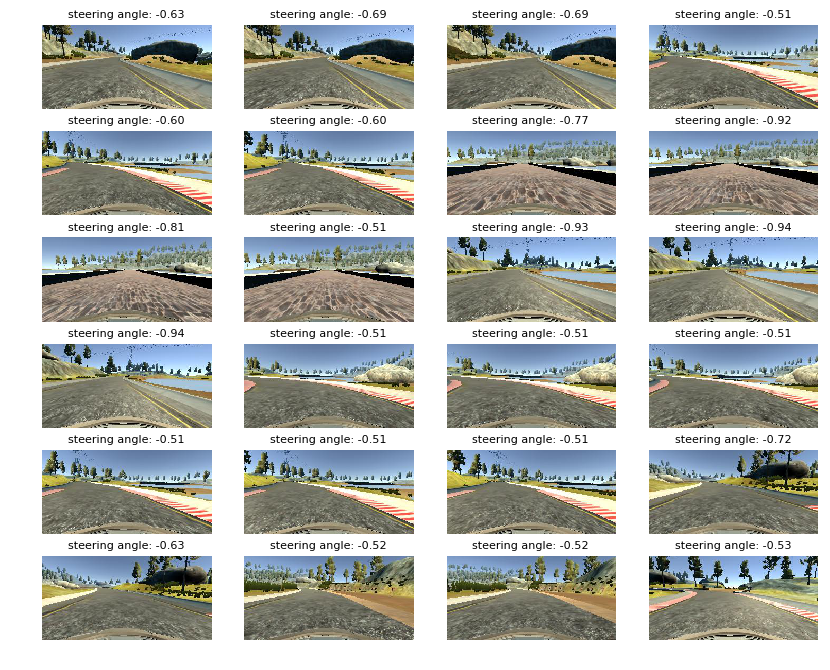

In [7]:
# Exploring values within a certain range. 
idx = np.flatnonzero(steering < -0.5)
plot_random_sample(idx, 4)

In [8]:

N = len(files)
samples = np.random.choice(N, N, replace=False)
N_training = int(N * .90)

training_files = [files[samples[i]] for i in range(N_training)]
training_angles = [steering[samples[i]] for i in range(N_training)]

testing_files = [files[samples[i]] for i in range(N_training, N)]
testing_angles = [steering[samples[i]] for i in range(N_training, N)]

In [12]:
from train import *
from generator import validation_generator
from generator import training_generator

data = pd.read_csv("data/driving_log.csv")

0.5 8036


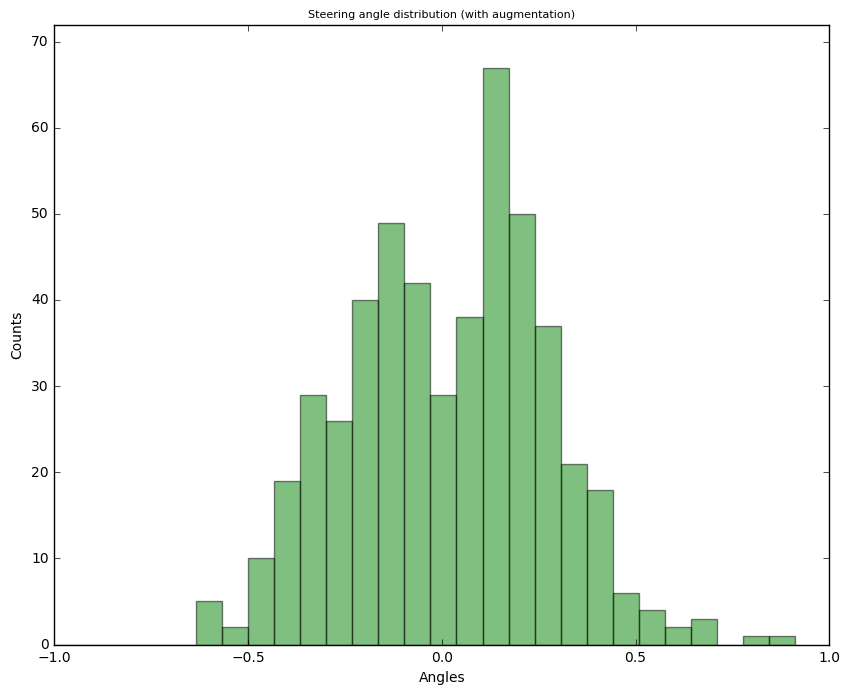

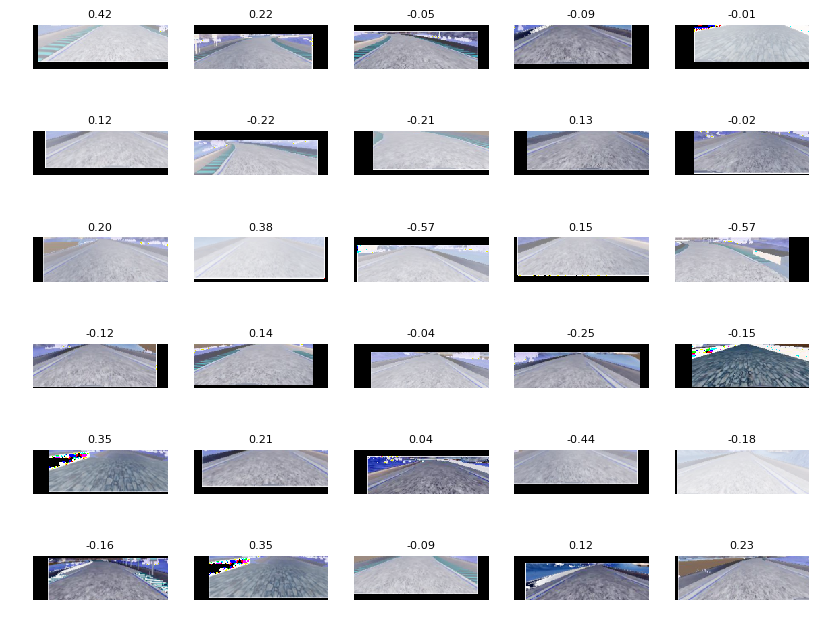

In [16]:
from model import *

train_X, train_y = next(training_generator(data, 0.5, 500))

n, bins, _ = plt.hist(train_y, 30, facecolor='green', alpha=0.5)
plt.plot(bins)
plt.title('Steering angle distribution (with augmentation)')
plt.xlabel('Angles')
plt.ylabel('Counts')
plt.axis([-1, 1, 0, max(n)+5])

plt.show()

plt.figure()
idxs = np.random.choice(train_X.shape[0], 30)
for i in range(len(idxs)):
    img = train_X[idxs[i]]
    plt.subplot(6, 5, i+1)
    plt.imshow(img.astype('uint'))
    plt.axis("off")
    plt.title("%0.2f"%(train_y[idxs[i]]))
        

In [ ]:
row = 64
col = 64
ch = 3

model = getModel('nvidia')
model.compile(optimizer="adam", loss="mse")

EPOCHS = 10

cnt = 0
for i in range(EPOCHS):
    bias = 1. / (cnt + 1.)
    
    print (bias)
    history = model.fit_generator(
                    training_generator(training_files, training_angles, bias, 128), 
                    samples_per_epoch=20000, 
                    validation_data=validation_generator(testing_files, testing_angles, 128),
                    nb_val_samples=1000,
                    nb_epoch=1, 
                    verbose=2)
    cnt +=1
    
model.save("steering_model_nvidia.h5")
print ("Model saved")

In [ ]:
if 'acc' in history.history:
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

if 'loss' in history.history:
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

In [ ]:
valid_X, valid_y = next(validation_generator(testing_files, testing_angles, 50))
pred_y = model.predict(valid_X)

print (valid_y)
print (pred_y)
#print (pred_y.reshape(-1))
#print (   ((valid_y - pred_y.reshape(-1)) ** 2).mean() )

valid_X, valid_y = next(validation_generator(testing_files, testing_angles, 9))
pred_y = model.predict(valid_X)
for i in range(valid_X.shape[0]):
    img = valid_X[i]
    plt.subplot(3, 3, i+1)
    plt.imshow(img)
    plt.axis("off")
    plt.title("%0.2f / (%0.2f)"%(valid_y[i], pred_y[i]))